In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from torchmetrics import Accuracy
from torch.optim import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Mounted at /content/drive
Device cuda


# Clasificador de imágenes de comida

---


***Laura Valentina Hernández***

### ¿Buscando recetas de comida en Instragram?
Instagram es ampliamente usado para buscar recetas de diferentes comidas puesto que puede proporcionar imágenes del paso a paso, e incluso lo más importante, el resultado final. Estas recetas varían de un pastel a un mazorcada. Pero ¿Cómo puede una aplicación como Instagram identificar que esa imagen es una sopa de tomate ?

Bueno uno de los métodos para lograrlo es la clasificación de imágenes, donde se toma la imagen subida por un usuario y se trata de identificar los objetos en ella para poderla clasificar, taggearla y posteriormente sugerirla al usuario.

¡Esto nos parece  un concepto muy interesante! Por esta razón, en este notebook queremos explorar de qué forma se puede implementar un clasificador de imágenes de comida, que tenga una precisión considerable, usando el machine learning.
 Para esto, escogimos 5 tipos de comida que son conocidos mundialmente, además de deliciosos! Estos son:


*   Helado
*   Hamburguesa
*   Perro caliente
*   Sanduche
*   Cheesecake

Las imágenes de estas comidas vienen de diferentes búsquedas y recursos de Google. Son imágenes a color y cada una de las categorías tiene entre 850 y 1100 imágenes. Para más información se puede visitar la fuente donde obtuvimos las imágenes en el siguiente link. https://www.kaggle.com/datasets/gauravduttakiit/food-image-classification/data

Afortunadamente todas las imágenes tienen la misma dimensión de 512x512 pixeles, pero al ser extraídas de internet,y como el mismo repositorio lo dice, tienen harta diversidad, es decir podemos encontrar tanto imágenes ideales como también imágenes que pueden tener objetos adicionales.

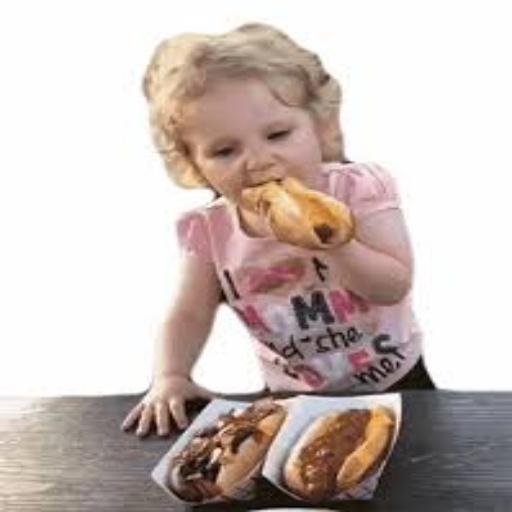

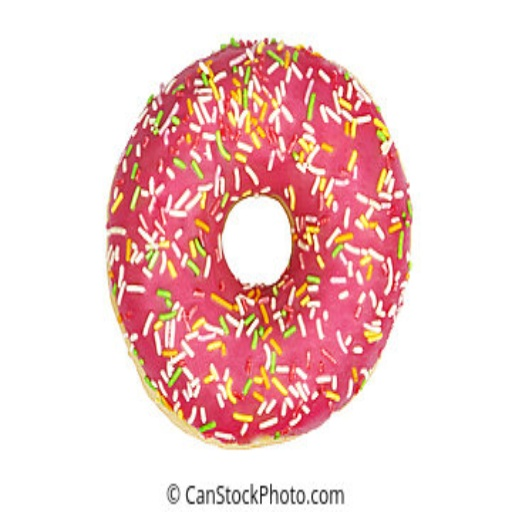

La de la derecha es una imagen ideal de dona, la de la izquierda es una imagen categorizada como perrito caliente, pero, como es evidente, tiene más que un perrito caliente.

Al mirar cada una de las carpetas, si existían imágenes que pueden no ser directamente el objeto, pero eran muy pocas respecto a las imagenes que sí eran el objeto. Predominaban sobre todo en la categoría de perrito caliente. No eliminamos estas imagenes proque queremos conservar el dataset original y sería interesante mirar si pueden aportar cierta variación.

## Secciones

* [¿Qué pasa si el dataset son imágenes?](#dataset).
   
* [¿Qué pasa si probamos con una red lineal?](#lineal).

* [El primer vistazo a las redes convolucionales](#p_conv).
    - ¿Qué son las redes convolucionales?
    - Primera implementación
*   [¿Se pueden mejorar los datos?](#convi)
    - Normalización
*   [¿Y qué pasa con los hiperpárametros?](#convi)
    - Learning rate
    - Tamaño del kernel, padding, etc

* [En busca de nuevas arquitecturas](#arqui)
    - ¿Añadimos más capas lineales o convolucionales?
    - Arquitecturas pequeñas
    - ¿Qué pasa si regularizamos?
    - Experimentando más a fondo
* [Curiosidades con la escala de grises](#arqui).

* [Conclusiones](#conclusiones).

## *¿Qué pasa si el dataset son imágenes?*

Para poder usar nuestras imágenes como un data set tenemos que tomar cada una como una matriz donde cada entrada es un pixel. Si se toma la imagen en escala de grises cada elemento de la matriz es o cero o uno. Por otro lado si tomamos las imagen a color, cada elemento de la matriz es un vector de 1x3 que representa la escala RGB que va del 0 al 255.

Para tener las categorías de las imágenes tomamos un directorio grande llamado imlgml y dentro almacenamos los subdirectorios con las imágenes de cada categoría. Posteriormente usamos el método ImageFolder para que cada una tuviera un valor del 0 al 4.

En este caso le modificamos el tamaño a las imágenes a 100x100 pixeles para optimizar el tiempo de ejecución que requerían los entrenamientos.


<a class="anchor" id="dataset"></a>

## ¿Qué pasa si probamos con una red lineal?

<a class="anchor" id="lineal"></a>
Como punto de partida vamos a tomar una red neuronal lineal y vamos a pasarle las imágenes para ver cómo es su desempeño y evaluar si es necesario usar otro tipo de arquitectura para poder clasificar correctamente las imágenes.

Como nuestra red es lineal no podemos tomar directamente la matriz generada por la imagen. Lo que vamos a hacer es convertir esa matriz en un vector fila pegando cada fila una después de otra.


In [ ]:
!cp -r /content/drive/MyDrive/imgml imgml #cargamos los datos a colab como tal para que corra más rápido
path = "imgml"
transform = T.Compose([T.Resize((100, 100)),T.ToTensor()])
dataset1 = ImageFolder(root=path, transform=transform)
dataset1.transform = T.Compose([transform, lambda x: x.view(-1)])

Teniendo ya las imágenes vamos a partir en los conjuntos de entrenamiento, testeo y validación.

In [ ]:
t4,t5,t6  = torch.utils.data.random_split(dataset1,[0.7, 0.15, 0.15])
train_data1 = DataLoader(t4, batch_size=16, shuffle=True)
val_data1 = DataLoader(t5, batch_size=16, shuffle=True)
test_data1 = DataLoader(t6, batch_size=16, shuffle =True)

## Modelo inicial


En este caso vamos a tomar una red de 20 nodos en todas las capas con la función de activación ReLu, además de eso vamos a tomar la función de pérdida como NLLLoss puesto que es un problema de clasificación con C= 5 categorías.

El número de nodos de entrada es 30000 pues cada imagen es de 100x100 pixeles y cada pixel tiene las tres entradas del rgb.



In [ ]:
class Normal_net(nn.Module):
    def __init__(self,num_nodos,num_atributos = 30000):
        super(Normal_net,self).__init__()
        self.num_nodos = num_nodos
        self.num_atributos = num_atributos



        self.fc1 = nn.Linear(self.num_atributos,self.num_nodos)
        self.act_fn1 = nn.ReLU()

        self.fc2 = nn.Linear(self.num_nodos,20)
        self.act_fn2 = nn.Sigmoid()

        self.fc3 = nn.Linear(20,5)

    def forward(self, x):

        # Usar las capas inicializadas y devolver x
        x = self.fc1(x)
        x = self.act_fn1(x)
        x = self.fc2(x)
        x = self.act_fn2(x)
        x = self.fc3(x)
        return x

Definimos la función de entrenamiento y luego probamos un el test dataset.

In [ ]:
def train_model(model,optimizer,loss_module,train_loader,valid_loader,num_epochs):

  valid_loss_min =np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'

  for i in range(num_epochs):
    model.train()  #ponemos el modelo en modo entrenamiento. Es importante en otras arquitecturas como redes convolucionales.
    train_loss = 0.0
    valid_loss = 0.0

    for data, target in train_loader:


        data_inputs = data.to(device)
        data_labels = target.to(device)
        model = model.to(device)
        optimizer.zero_grad()
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        loss = loss_module(preds, data_labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(train_loader.dataset)

    model.eval()

    for data,target in valid_loader:
      data=data.to(device)
      target=target.to(device)
      output=model(data)
      loss= criterion(output, target.long())
      valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)

    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'first_model.pt')
        valid_loss_min = valid_loss

Cargamos el modelo ya entrenado

In [ ]:

modelo_1= Normal_net(20)
modelo_1.load_state_dict(torch.load("/content/drive/MyDrive/train/first_model.pt"))
modelo_1.eval()
modelo_1 = modelo_1.to(device)

In [ ]:
test_loss=0.0

criterion =  nn.NLLLoss()
t_pred = torch.empty((1,5))
t_pred = t_pred.to(device)

og = torch.empty((1))
og = og.to(device)

for data, target in test_data1:
  data = data.to(device)
  target = target.to(device)
  output = modelo_1(data)

  loss = criterion(output,target.long())
  test_loss += loss.item()*data.size(0)
  t_pred = torch.cat((t_pred,output))

  og = torch.cat((og,target))

test_loss = test_loss/len(test_data1.dataset)

pred =  torch.argmax(t_pred[1:],dim=1)
pred = pred.to(device)
accuracy = Accuracy(task="multiclass", num_classes=5).to(device)
acc = accuracy(pred,og[1:])
print(f'Accuracy: {round(acc.item()*100,4)} %')


Accuracy: 21.4467 %


Con esto podemos ver que con una red normal las predicciones no son tan buenas puesto que el algortimo tiene casi los mismo resultados que escoger una categoría de manera aletoria. Esto quiere decir que necesitamos una mejor arquitectura que se adapte mejor al tipo de datos en formato  imagen.

## El primer vistazo a las redes convolucionales


La cuestión ahora es por qué no tienen un buen funcionamiento estas redes. Bueno, en imágenes muy básicas que cumplan características específicas, como que los objetos estén en la misma posición, o que tengan pocos elementos, las redes lineales pueden funcionar, pero si tomamos fotos de la vida real sin ningún tipo de edición, este es rara vez el caso. Además de eso, la cantidad de información que debe procesar la red puede escalar muy rápido, por ejemplo en nuestro caso tenemos 100x100x3 = 30,000 atributos, lo cual puede dificultar el funcionamiento.

Por fortuna se tiene una solución! ***Las redes convolucionales***

Las redes convolucionales es una  arquitectura comunmente usada en el campo del deep learning, especialmente en la clasficiación de imágenes y el reconocimiento de objetos. Estas redes mejoran el procesamiento de la información puesto que pueden reducir la dimensionalidad que el modelo necesita para aprender de una imagen sin perder características importantes para la clasificación de la imagen. Es decir, pueden identificar los patrones por medio de filtros y capturar la "escencia" de la imagen.

Mencionemos algunos aspectos importantes:

Esta arquitectura se puede ver como inputs, filtros, capa convolucional,pooling y flattening.

   

1.   El input en este caso en la matriz de la imagen.
2.   La capa convolucional es el bloque estructural de esta red.  Se toman fitros y se convolucionan con la imagen para obtener la información de las características. En esta capa tenemos:
*   Kernel: Es una matriz nxn que se desliza a lo largo de toda la imagen y va multiplicando pixel por pixel para luego sumar los valores. El kernel es un filtro o identificador de características.



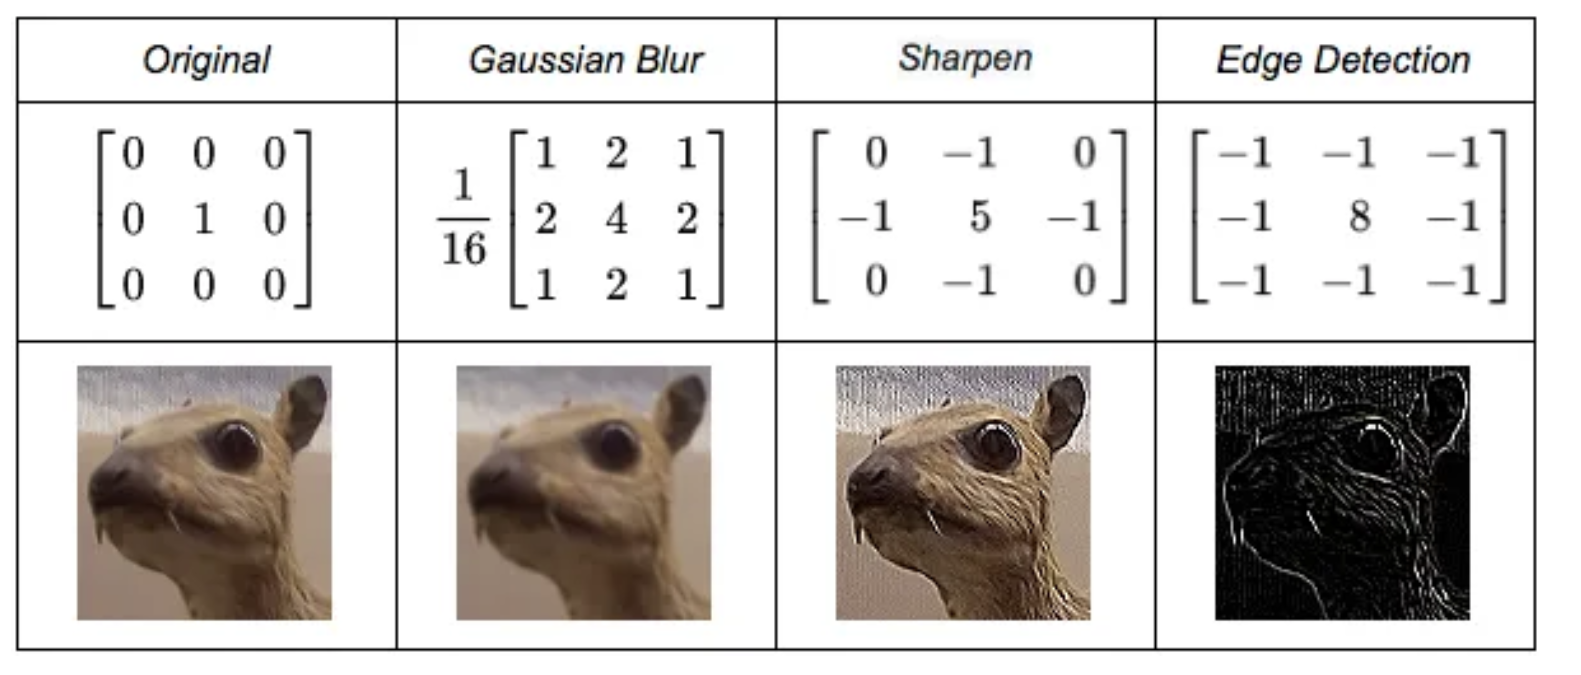

*   Padding: Para no perder información de los bordes, el padding es el número de pixeles blancos que se añaden al borde de la imagen.

*   Stride: Es el número de pixeles que se va a mover el filtro después de cada iteración.


*   Mapa de características: Es el output de una capa convolucional que representa carcterísticas importantes de la imagen.

3. Pooling: Reduce la dimensión pero mantiene la información más importante.
4.  Flatenning: Convierte la matriz en un vector fila para poder conectar la red.
5.  Red lineal.


Ahora que sí tenemos claro que es una red convolucional, manos a la obra!



# Implementando una red convolucional

#### Criterio usado
Para este problema decidimos usar CROSSENTROPYLOSS como criterio principalmente porque queremos clasificar imágenes con C = 5. Además de eso nuestros datos no están completamente balanceados, pues tenemos categorías de 800 y otras de 1100. Por otro lado queremos como salida una probabilidad junto al uso del softmax en la última capa,luego usando este criterio podemos minimizar la diferencia entre la probabilidad predecida y la real.


Ahora si, primero vamos a volver a obtener los datos, pero esta vez en forma de matriz.

In [ ]:
dataset = ImageFolder(root=path, transform=transform)
dataset.transform = transform

t4,t5,t6  = torch.utils.data.random_split(dataset,[0.7, 0.15, 0.15])
train_data = DataLoader(t4, batch_size=16, shuffle=True, drop_last=True)
val_data = DataLoader(t5, batch_size=16, shuffle=True)
test_data  = DataLoader(t6, batch_size=16, shuffle =True)

Declaramos nuestras funciones de entrenamiento y testo.

In [ ]:
def train_convolutional(model,optimizer,loss_module,train_loader,valid_loader,n_epochs):

    for epoch in range(n_epochs):

        model.train()
        for inputs, labels in train_loader:
            #Pasasmos todo a gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)

            # forward, backward,  update de pesos
            y_pred = model(inputs)
            loss = loss_module(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc = 0
        count = 0

        #probamos el módelo con el test data
        model.eval()
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_pred = model(inputs)
            # print(y_pred)
            acc += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
        acc /= count
        print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

In [ ]:
def test(model,test_data):
    test_loss=0.0

    criterion =  nn.CrossEntropyLoss()
    t_pred = torch.empty((1,5))
    t_pred = t_pred.to(device)

    og = torch.empty((1))
    og = og.to(device)

    for data, target in test_data:
      data = data.to(device)
      target = target.to(device)
      output = model(data)

      loss = criterion(output,target.long())
      test_loss += loss.item()*data.size(0)
      t_pred = torch.cat((t_pred,output))

      og = torch.cat((og,target))

    test_loss = test_loss/len(test_data.dataset)
   # print('Test Loss: {:.6f}\n'.format(test_loss))

    pred =  torch.argmax(t_pred[1:],dim=1)
    pred = pred.to(device)
    accuracy = Accuracy(task="multiclass", num_classes=5).to(device)
    acc = accuracy(pred,og[1:])
    print(f'Accuracy: {round(acc.item()*100,4)} %')
    return acc



Primero vamos a intentar con una red con dos capas convolucionales, la primera con 6 channels out y la segunda con 5. Para ambas vamos a tomar un stride y padding de uno y un kernel de 2x2.

Al final de la red tenemos una capa normal con ReLu y otra con Softmax para obtener las probabilidades.

In [86]:
# @title  Red convolucional inicial
class red_basica(nn.Module):
    def __init__(self):
        super().__init__()
        #primera capa con1 ch_in,6 filtros, tamaño del filtro3x3, se mueve de a uno y tiene un pxiel de borde
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(2,2), stride=1, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(6, 5, kernel_size=(2,2), stride=1, padding=1)
        self.act2 = nn.ReLU()

        #selecciona el mayor valor en el 2x2 y ese lo deja para pasarlo a la red normal
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        #lo vuelve todo un array
        self.flat = nn.Flatten()

        #red lineal que devuelve la prob
        self.fc3 = nn.Linear(13005, 7)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(7, 5)
        self.act4 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.conv1(x))

        x = self.act2(self.conv2(x))

        x = self.pool3(x)

        x = self.flat(x)

        x = self.act3(self.fc3(x))

        x = self.act4(self.fc4(x))
        return x



In [88]:
model = red_basica()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
train_convolutional(model,optimizer,loss_fn,train_data,val_data,15)

Epoch 0: model accuracy 15.86%
Epoch 1: model accuracy 15.86%
Epoch 2: model accuracy 25.89%
Epoch 3: model accuracy 23.22%
Epoch 4: model accuracy 22.72%
Epoch 5: model accuracy 22.84%
Epoch 6: model accuracy 22.84%
Epoch 7: model accuracy 22.97%
Epoch 8: model accuracy 22.97%
Epoch 9: model accuracy 24.24%
Epoch 10: model accuracy 25.38%
Epoch 11: model accuracy 24.87%
Epoch 12: model accuracy 25.51%
Epoch 13: model accuracy 25.25%
Epoch 14: model accuracy 25.13%


In [90]:
test(model,test_data)

Accuracy: 22.7157 %


tensor(0.2272, device='cuda:0')

Como podemos ver, nuesto modelo no es que haya mejorado mucho la precisión respecto al primero que probamos. ¿Qué podrá ser?
Antes de probar otras arquitecturas, podemos pensar si los datos necesitan algún tipo de modificación para mejorar el desempeño.

Para desarrollar nuestra arquitectura decidimos hacerlo de manera experimental teniendo en cuenta los aspectos claves de redes famosas y precisas para clasificaicón como lo es ResNet. Esta red implementa regularización, normalización en los batches, intenta con diferentes hiperparámetros  y tamaños de red.
Esto es lo que haremos a continuación.

# ¿Podemos mejorar los datos?

Una de las técnicas que se prueban es remover variables, en este caso no es muy conveniente , puesto que cada una de las entradas es un pixel y con el max poolin justamente reducimos la dimensión, luego reducir el número de variables no sería muy favorecedor.

Pero, si volvemos a pensar en nuestros datos, podemos ver que el intervalo es 0 a 255, lo que nos lleva a pensar, ¿Qué puede cambiar si normalizamos? Para esto podemos usar ***BatchNorm2d*** de Torch. Esto es una capa de normalización especial para datos en 2d como las imágenes que toma lotes  y para cada pixel canal de entrada calcula la media y la varianza en todo el lote  y los normaliza.


In [ ]:
# @title Red Convolucional normalizando
class red_normalizando(nn.Module):
    def __init__(self):
        super().__init__()
        #primera capa con1 ch_in,6 filtros, tamaño del filtro3x3, se mueve de a uno y tiene un pxiel de borde
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(2,2), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(6, 5, kernel_size=(2,2), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(5)
        self.act2 = nn.ReLU()

        #selecciona el mayor valor en el 2x2 y ese lo deja para pasarlo a la red normal
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        #lo vuelve todo un array
        self.flat = nn.Flatten()

        #red lineal que devuelve la prob
        #self.fc3 = nn.Linear(2645, 7)
        self.fc3 = nn.Linear( 13005, 7)

        self.bn3 = nn.BatchNorm1d(7)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(7, 5)
        self.act4 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.conv1(x)))

        x = self.act2(self.bn2(self.conv2(x)))

        x = self.pool3(x)

        x = self.flat(x)

        x = self.act3(self.bn3(self.fc3(x)))

        x = self.act4(self.fc4(x))
        return x


In [ ]:
model_n = red_normalizando()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_n.parameters(), lr=0.001)
train_convolutional(model_n,optimizer,loss_fn,train_data,val_data,10)

Epoch 0: model accuracy 40.74%
Epoch 1: model accuracy 43.40%
Epoch 2: model accuracy 44.92%
Epoch 3: model accuracy 45.56%
Epoch 4: model accuracy 44.80%
Epoch 5: model accuracy 44.04%
Epoch 6: model accuracy 43.65%
Epoch 7: model accuracy 44.80%
Epoch 8: model accuracy 44.92%
Epoch 9: model accuracy 45.43%


In [ ]:
test(model_n,test_data)

Accuracy: 46.4467 %


tensor(0.4645, device='cuda:0')

Como podemos ver esto fue un factor determinante en el desempeño de nuestro modelo, con solo ese cambio, ya subió casi que un 20%, lo cual es totalmente entendible teniendo en cuenta la escala. Por esta razón en las siguientes implementaciones vamos a conservar la normalización.

# Misma arquitectura, diferentes hiperpárametros.

### ¿Qué hacemos con el learning rate?

Para ver si podemos mejorar el desempeño decidimos usar Adam, el cual es un learning rate adaptativo que según como va viendo el comportamiento aumenta o disminuye alpha para poder llegar a  la convergencia.



In [ ]:
model_a = red_normalizando()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_a.parameters(), lr=0.001)
train_convolutional(model_a,optimizer,loss_fn,train_data,val_data,10)
test(model_a,test_data)


Epoch 0: model accuracy 43.15%
Epoch 1: model accuracy 45.30%
Epoch 2: model accuracy 50.00%
Epoch 3: model accuracy 49.49%
Epoch 4: model accuracy 48.48%
Epoch 5: model accuracy 50.76%
Epoch 6: model accuracy 52.92%
Epoch 7: model accuracy 51.65%
Epoch 8: model accuracy 51.78%
Epoch 9: model accuracy 47.21%
Accuracy: 51.3959 %


tensor(0.5140, device='cuda:0')

Como podemos ver, al usar Adam nuestro desempeño mejora! Además de eso probamos con diferentes learning rates y el de mejor desempeño se quedó en el lr = 0.001 inicial.
 Luego también lo vamos a usar en las redes siguientes.

### Tamaño del kernel, padding y stride
Ahora podemos pensar cuál es el tamaño del kernel más adecuado, cual es el mejor stride, que padding necesitamos. Para resolver estas preguntas podemos hacer pruebas de manera experimental. Con el fin de poder unificar todas las pruebas en un solo proceso vamos a reemplazar el método maxpooling por Adaptive pooling para poder controlar los canales de salida. Con base a las redes pasadas tomamos como dimensión 21x150.

In [ ]:
class red_pruebas(nn.Module):
    def __init__(self,kernel_1,kernel_2,n_1,n_2,n_3,s_1,pad,n):
        super().__init__()

        k = 31500*n
        self.conv1 = nn.Conv2d(3, n_1, kernel_size=(kernel_1,kernel_1), stride=s_1, padding=pad)
        self.bn1 = nn.BatchNorm2d(n_1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(n_1, n_2, kernel_size=(kernel_2,kernel_2), stride=s_1, padding=pad)
        self.bn2 = nn.BatchNorm2d(n_2)
        self.act2 = nn.ReLU()

        self.pool3 = nn.AdaptiveAvgPool2d((21,150))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(k, n_3)
        self.bn3 = nn.BatchNorm1d(n_3)
        self.act3 = nn.ReLU()


        self.fc4 = nn.Linear(n_3, 5)
        self.act4 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.conv1(x)))

        x = self.act2(self.bn2(self.conv2(x)))

        x = self.pool3(x)

        x = self.flat(x)

        x = self.act3(self.bn3(self.fc3(x)))


        x = self.act4(self.fc4(x))
        return x

Vamos a intentar con un tamaño de kernel de 2x2, 3x3, 5x5,10x10,15x15 y 30x30.
Para el número de nodos vamos a probar con 10,30,50 y 80.
Para el stride con 1,2,4.
Para el padding 1,2,4,6.

In [ ]:
ker_1 = [2,3, 5,10,15,30]
num_nodos =[10,30,50,80]
s_1 = [1,2,4]
pad =[1,2,4,6]

def pruebas(ker_1,num_nodos,s_1,pad):
  ac = 0
  parameters=[]
  loss_fn = nn.CrossEntropyLoss()

  for a in ker_1:
    for b in ker_1:
      for c in num_nodos:
        for d in num_nodos:
           for e in num_nodos:
              for f in s_1:
                for g in pad:
                      model_p = red_pruebas(a,b,c,d,e,f,g,(c//10))
                      optimizer = Adam(model_p.parameters(), lr=0.001)
                      train_convolutional(model_p,optimizer,loss_fn,train_data,val_data,3)
                      m = test(model_p,test_data)
                      if m>ac:
                        ac=m
                        parameters=[a,b,c,d,e,f,g]

  print(ac)
  print(parameters)

  return ac,parameters

#pruebas(ker_1,num_nodos,s_1,pad)



El resultado de esta prueba de hiperparámetros fue que el mayor accuracy que fue de 54% se obtenía con 50 nodos en la primera capa convolucional, 80 en la segunda y 50 en la capa lineal. Para el kernel, el mejor fue 2x2 en ambas capas , el padding 4 y el stride 2.(En este caso no lo corremos porque el tiempo de ejecuación es largo), por lo cual vamos a extrapolar estos resultados para construir una red más robusta.

Fue curioso ver como no fue el resultado esperado, por ejemplo teniendo tamaño 30x30 en ambos kernels, al accuracy fue de 39.34%.

# En búsqueda de nuevas arquitecturas

###¿ Más capas convolucionales o lineales?

Una de las cosas más interesantes para pensar  es si agregamos más capas convolucionales o lineales. Para esto hicimos ciertas pruebas para ver cómo cambiaba el accuracy con redes como la siguiente y pudimos ver que no representaban una mejora significativa en el desempeño, luego nos vamos fijar en construir mejores capas convolucionales y dejar las lineales que ya estaban.

In [ ]:
class red_morelinear(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.act2 = nn.ReLU()


        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))


        self.flat = nn.Flatten()


        self.fc3 = nn.Linear( 13005, 100)

        self.bn3 = nn.BatchNorm1d(7)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear( 100, 50)
        self.act4 = nn.ReLU()

        self.fc5 = nn.Linear( 50, 10)
        self.act5 = nn.ReLU()

        self.fc6 = nn.Linear(10, 5)
        self.act6 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.conv1(x)))

        x = self.act2(self.bn2(self.conv2(x)))

        x = self.pool3(x)

        x = self.flat(x)

        x = self.act3(self.bn3(self.fc3(x)))

        x = self.act4(self.fc4(x))

        x = self.act5(self.fc5(x))

        x = self.act6(self.fc6(x))
        return x


Con redes similares a estas pero con más capas pudimos ver que disminuye el accuracy, luego vamos a conservar el número de lineales implementadas en la red 1.

No obstante, algo curioso fue que más adelante en otros modelos pudimos evidenciar como quitando esa capa lineal que usa ReLu el modelo reduce su desempeño.¡Curioso!

# Buscando la robustez del modelo
 A continuación mostraremos como de manera experimental intentamos varias arquitecturas e hiperparámetros hasta llegar a la elegida.

Empezamos añadiendole otra capa convolucional a la primera red.

In [ ]:
class red_2(nn.Module):
    def __init__(self):
        super().__init__()
        #primera capa con1 ch_in,5 filtros, tamaño del filtro3x3, se mueve de a uno y tiene un pxiel de borde
        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.act4 = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc5 = nn.Linear(3600 , 70)
        self.bn5 = nn.BatchNorm1d(70)
        self.act5 = nn.ReLU()



        self.fc6 = nn.Linear(3600, 5)
        self.act6 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.conv1(x)))


        x = self.act2(self.bn2(self.conv2(x)))

        x = self.act3(self.bn3(self.conv3(x)))

        x = self.act4(self.bn4(self.conv4(x)))

        x = self.pool3(x)

        x = self.flat(x)

        x = self.act5(self.bn5(self.fc5(x)))
        x = self.act6(self.fc6(x))


        return x

In [ ]:
model_r2 = red_2()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r2.parameters(), lr=0.001)

train_convolutional(model_r2,optimizer,loss_fn,train_data,val_data,20)

Epoch 0: model accuracy 40.10%
Epoch 1: model accuracy 39.34%
Epoch 2: model accuracy 42.77%
Epoch 3: model accuracy 44.92%
Epoch 4: model accuracy 48.22%
Epoch 5: model accuracy 50.00%
Epoch 6: model accuracy 50.76%
Epoch 7: model accuracy 56.85%
Epoch 8: model accuracy 54.19%
Epoch 9: model accuracy 56.35%
Epoch 10: model accuracy 54.70%
Epoch 11: model accuracy 59.26%
Epoch 12: model accuracy 60.53%
Epoch 13: model accuracy 58.88%
Epoch 14: model accuracy 59.26%
Epoch 15: model accuracy 60.28%
Epoch 16: model accuracy 60.41%
Epoch 17: model accuracy 60.66%
Epoch 18: model accuracy 60.53%
Epoch 19: model accuracy 62.06%


In [ ]:
test(model_r2,test_data)

Accuracy: 60.6599 %


tensor(0.6066, device='cuda:0')

Podemos ver que el accuracy aumento hasta 60%, lo cual nos sorprendió al ser una red con pocas capas. Ahora vamos a ver qué pasa si añadimos aún más capas. Intentemos ahora con otras dos nuevas capas convolucionales.

In [26]:
class red_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.act4 = nn.ReLU()



        self.conv5 = nn.Conv2d(100, 110, kernel_size=(3,3), stride=2, padding=4)
        self.bn5 = nn.BatchNorm2d(110)
        self.act5 = nn.ReLU()

        self.conv6 = nn.Conv2d(110, 120, kernel_size=(3,3), stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(120)
        self.act6 = nn.ReLU()



        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc7 = nn.Linear(1920, 50)
        self.bn7 = nn.BatchNorm1d(50)
        self.act7 = nn.ReLU()



        self.fc8= nn.Linear(50, 5)
        self.act8 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1((self.conv1(x))))

        x = self.act2(self.bn2((self.conv2(x))))

        x = self.act3(self.bn3((self.conv3(x))))

        x = self.act4(self.bn4((self.conv4(x))))

        x = self.act5(self.bn5((self.conv5(x))))

        x = self.act6(self.bn6(self.conv6(x)))


        x = self.pool3(x)

        x = self.flat(x)

        x = self.act7(self.bn7(self.fc7(x)))
        x = self.act8(self.fc8(x))


        return x

In [27]:
model_r3 = red_3()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r3.parameters(), lr=0.001)
train_convolutional(model_r3,optimizer,loss_fn,train_data,val_data,20)

Epoch 0: model accuracy 45.30%
Epoch 1: model accuracy 46.45%
Epoch 2: model accuracy 54.82%
Epoch 3: model accuracy 55.33%
Epoch 4: model accuracy 52.16%
Epoch 5: model accuracy 58.88%
Epoch 6: model accuracy 60.53%
Epoch 7: model accuracy 60.79%
Epoch 8: model accuracy 49.75%
Epoch 9: model accuracy 58.50%
Epoch 10: model accuracy 59.26%
Epoch 11: model accuracy 57.87%
Epoch 12: model accuracy 60.03%
Epoch 13: model accuracy 60.28%
Epoch 14: model accuracy 60.03%
Epoch 15: model accuracy 61.42%
Epoch 16: model accuracy 60.15%
Epoch 17: model accuracy 61.55%
Epoch 18: model accuracy 63.83%
Epoch 19: model accuracy 60.03%


In [28]:
test(model_r3,test_data)

Accuracy: 61.9289 %


tensor(0.6193, device='cuda:0')

Podemos ver que el accuracy siguió en  aumento. Pero podríamos explorar primero si hay mejores hiperparámetros para esta arquitectura.

In [51]:
class red_3c(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.act4 = nn.ReLU()



      #  self.conv5 = nn.Conv2d(100, 130, kernel_size=(3,3), stride=2, padding=4)
        self.conv5 = nn.Conv2d(100, 105, kernel_size=(3,3), stride=2, padding=4)
        self.bn5 = nn.BatchNorm2d(105)
        self.act5 = nn.ReLU()

       # self.conv6 = nn.Conv2d(130, 135, kernel_size=(3,3), stride=2, padding=4)
        self.conv6 = nn.Conv2d(105, 110, kernel_size=(3,3), stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(110)
        self.act6 = nn.ReLU()



        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc7 = nn.Linear(1760, 50)
        self.bn7 = nn.BatchNorm1d(50)
        self.act7 = nn.ReLU()



        self.fc8= nn.Linear(50, 5)
        self.act8 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1((self.conv1(x))))

        x = self.act2(self.bn2((self.conv2(x))))

        x = self.act3(self.bn3((self.conv3(x))))

        x = self.act4(self.bn4((self.conv4(x))))

        x = self.act5(self.bn5((self.conv5(x))))

        x = self.act6(self.bn6(self.conv6(x)))


        x = self.pool3(x)

        x = self.flat(x)

        x = self.act7(self.bn7(self.fc7(x)))
        x = self.act8(self.fc8(x))


        return x

In [52]:
model_r3c = red_3c()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r3c.parameters(), lr=0.001)
train_convolutional(model_r3c,optimizer,loss_fn,train_data,val_data,20)

Epoch 0: model accuracy 47.34%
Epoch 1: model accuracy 49.11%
Epoch 2: model accuracy 53.93%
Epoch 3: model accuracy 52.41%
Epoch 4: model accuracy 56.73%
Epoch 5: model accuracy 56.98%
Epoch 6: model accuracy 57.11%
Epoch 7: model accuracy 57.87%
Epoch 8: model accuracy 58.88%
Epoch 9: model accuracy 58.63%
Epoch 10: model accuracy 58.88%
Epoch 11: model accuracy 64.09%
Epoch 12: model accuracy 62.31%
Epoch 13: model accuracy 60.53%
Epoch 14: model accuracy 57.11%
Epoch 15: model accuracy 60.66%
Epoch 16: model accuracy 60.91%
Epoch 17: model accuracy 60.53%
Epoch 18: model accuracy 60.41%
Epoch 19: model accuracy 61.68%


In [53]:
test(model_r3c,test_data)

Accuracy: 58.6294 %


tensor(0.5863, device='cuda:0')

La red anterior fue la que mejor desempeño tuvo respecto a cambiar el número de in/out channels y los kernels.
### Eps y el learning rate
Ahora podemos probar con el Learning Rate. Probemos primero con diferentes valores.

In [55]:
model_a = red_3c()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_a.parameters(), lr=0.01)
train_convolutional(model_a,optimizer,loss_fn,train_data,val_data,10)
test(model_a,test_data)

Epoch 0: model accuracy 35.15%
Epoch 1: model accuracy 40.74%
Epoch 2: model accuracy 43.91%
Epoch 3: model accuracy 45.05%
Epoch 4: model accuracy 44.29%
Epoch 5: model accuracy 46.32%
Epoch 6: model accuracy 47.34%
Epoch 7: model accuracy 48.48%
Epoch 8: model accuracy 47.59%
Epoch 9: model accuracy 34.90%
Accuracy: 36.1675 %


tensor(0.3617, device='cuda:0')

In [56]:
model_a = red_3c()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_a.parameters(), lr=0.005)
train_convolutional(model_a,optimizer,loss_fn,train_data,val_data,10)
test(model_a,test_data)

Epoch 0: model accuracy 39.34%
Epoch 1: model accuracy 32.74%
Epoch 2: model accuracy 42.64%
Epoch 3: model accuracy 42.64%
Epoch 4: model accuracy 48.73%
Epoch 5: model accuracy 46.07%
Epoch 6: model accuracy 42.01%
Epoch 7: model accuracy 49.62%
Epoch 8: model accuracy 47.84%
Epoch 9: model accuracy 49.49%
Accuracy: 45.5584 %


tensor(0.4556, device='cuda:0')

In [60]:
model_a = red_3c()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_a.parameters(), lr=0.0001)
train_convolutional(model_a,optimizer,loss_fn,train_data,val_data,20)
test(model_a,test_data)

Epoch 0: model accuracy 43.53%
Epoch 1: model accuracy 47.72%
Epoch 2: model accuracy 54.70%
Epoch 3: model accuracy 56.35%
Epoch 4: model accuracy 57.23%
Epoch 5: model accuracy 55.33%
Epoch 6: model accuracy 54.44%
Epoch 7: model accuracy 54.57%
Epoch 8: model accuracy 53.43%
Epoch 9: model accuracy 54.44%
Epoch 10: model accuracy 55.20%
Epoch 11: model accuracy 53.05%
Epoch 12: model accuracy 52.79%
Epoch 13: model accuracy 53.17%
Epoch 14: model accuracy 56.73%
Epoch 15: model accuracy 53.93%
Epoch 16: model accuracy 55.46%
Epoch 17: model accuracy 52.79%
Epoch 18: model accuracy 54.06%
Epoch 19: model accuracy 53.43%
Accuracy: 52.4112 %


tensor(0.5241, device='cuda:0')

Con esto podemos ver que el mejor learning rate es el que ya se tenía de 0.001
Ahora queremos ver si con el parámetro eps en Adam que ayuda a la estabilidad númerica añadiendo el valor asignado al denominador.

In [63]:
model_a = red_3c()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_a.parameters(), lr=0.001, eps=1e-10)
train_convolutional(model_a,optimizer,loss_fn,train_data,val_data,10)
test(model_a,test_data)

Epoch 0: model accuracy 48.10%
Epoch 1: model accuracy 51.90%
Epoch 2: model accuracy 43.78%
Epoch 3: model accuracy 56.09%
Epoch 4: model accuracy 56.47%
Epoch 5: model accuracy 54.82%
Epoch 6: model accuracy 59.01%
Epoch 7: model accuracy 56.60%
Epoch 8: model accuracy 54.19%
Epoch 9: model accuracy 60.41%
Accuracy: 58.2487 %


tensor(0.5825, device='cuda:0')

¡Con esto podemos ver que el parámetro eps no contribuye tanto !

### ¿Y si regularizamos?

Lo último que podemos probar es ver si nuestro modelo está sufriendo de overfitting. Por esta razón vamos a implementar un método de regularización. Uno de los métodos en redes neuronales es usar el método dropout. Este consiste en cada iteración "sacar" del entrenamiento a ciertas neuronas de manera aleatorea para forzar la robustez en el modelo entrenando a todas la neuronas por igual.



In [44]:
class red_3_reg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.dropout3 = nn.Dropout(p=0.2)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.dropout4 = nn.Dropout(p=0.2)
        self.act4 = nn.ReLU()



        self.conv5 = nn.Conv2d(100, 105, kernel_size=(3,3), stride=2, padding=4)
        self.bn5 = nn.BatchNorm2d(105)
        self.dropout5 = nn.Dropout(p=0.2)
        self.act5 = nn.ReLU()

        self.conv6 = nn.Conv2d(105, 110, kernel_size=(3,3), stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(110)
        self.act6 = nn.ReLU()



        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc7 = nn.Linear(1760, 70)
        self.bn7 = nn.BatchNorm1d(70)
        self.act7 = nn.ReLU()



        self.fc8= nn.Linear(70, 5)
        self.act8 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.dropout1(self.conv1(x))))

        x = self.act2(self.bn2(self.dropout2(self.conv2(x))))

        x = self.act3(self.bn3(self.dropout3(self.conv3(x))))

        x = self.act4(self.bn4(self.dropout4(self.conv4(x))))

        x = self.act5(self.bn5(self.dropout5(self.conv5(x))))

        x = self.act6(self.bn6(self.conv6(x)))


        x = self.pool3(x)

        x = self.flat(x)

        x = self.act7(self.bn7(self.fc7(x)))
        x = self.act8(self.fc8(x))


        return x

In [47]:
model_r3_r = red_3_reg()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r3_r.parameters(), lr=0.001)
train_convolutional(model_r3_r,optimizer,loss_fn,train_data,val_data,20)

Epoch 0: model accuracy 39.59%
Epoch 1: model accuracy 41.62%
Epoch 2: model accuracy 41.62%
Epoch 3: model accuracy 48.60%
Epoch 4: model accuracy 43.53%
Epoch 5: model accuracy 48.60%
Epoch 6: model accuracy 44.29%
Epoch 7: model accuracy 53.81%
Epoch 8: model accuracy 55.33%
Epoch 9: model accuracy 50.89%
Epoch 10: model accuracy 54.44%
Epoch 11: model accuracy 57.49%
Epoch 12: model accuracy 51.02%
Epoch 13: model accuracy 60.28%
Epoch 14: model accuracy 63.58%
Epoch 15: model accuracy 51.90%
Epoch 16: model accuracy 62.94%
Epoch 17: model accuracy 60.79%
Epoch 18: model accuracy 61.42%


In [48]:
test(model_r3_r,test_data)

Accuracy: 60.1523 %


tensor(0.6015, device='cuda:0')

Podemos ver que sí estaba haciendo un leve overfitting, luego vamos a conservar la regularización.

### Experimentando más a fondo.

Curiosamente para este dataset con los modelos de aquí en adelante el desempeño estuvo dificíl de mejorar. Por más arquitecturas y métodos de mejora intentados no pudimos llegar a una mejor red.
Intentamos modificar cada uno de los hiperpárametros a mano, modificando los in y out channels, los paddings y el stride. Intentamos con diversas organizaciones como aumentar los canales de manera ascendente y descendente intentamos también con diferentes valores para los drop outs y no se veía una mejora notable. A continuación mostramos los intentos más éxitosos que se construyeron con redes más grandes.

In [66]:

class red_4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 50, kernel_size=(2,2), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.dropout3 = nn.Dropout(p=0.2)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.dropout4 = nn.Dropout(p=0.2)
        self.act4 = nn.ReLU()



        self.conv5 = nn.Conv2d(100, 105, kernel_size=(2,2), stride=2, padding=4)
        self.bn5 = nn.BatchNorm2d(105)
        self.dropout5 = nn.Dropout(p=0.2)
        self.act5 = nn.ReLU()

        self.conv6 = nn.Conv2d(105, 110, kernel_size=(2,2), stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(110)
        self.dropout6 = nn.Dropout(p=0.2)
        self.act6 = nn.ReLU()


        self.conv7 = nn.Conv2d(110, 125, kernel_size=(2,2), stride=2, padding=4)
        self.bn7 = nn.BatchNorm2d(125)
        self.dropout7 = nn.Dropout(p=0.2)
        self.act7 = nn.ReLU()

        self.conv8 = nn.Conv2d(125, 130, kernel_size=(2,2), stride=2, padding=4)
        self.bn8 = nn.BatchNorm2d(130)
        self.dropout8 = nn.Dropout(p=0.2)
        self.act8 = nn.ReLU()


        self.conv11 = nn.Conv2d(130, 135, kernel_size=(2,2), stride=2, padding=4)
        self.bn11 = nn.BatchNorm2d(135)
        self.dropout11 = nn.Dropout(p=0.2)
        self.act11 = nn.ReLU()







        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc9 = nn.Linear(2160 , 50)
        self.bn9 = nn.BatchNorm1d(50)
        self.act9 = nn.ReLU()



        self.fc10 = nn.Linear(50, 5)
        self.act10 = nn.Softmax(dim=1)


    def forward(self, x):

        x = self.act1(self.bn1(self.dropout1(self.conv1(x))))

        x = self.act2(self.bn2(self.dropout2(self.conv2(x))))

        x = self.act3(self.bn3(self.dropout3(self.conv3(x))))

        x = self.act4(self.bn4(self.dropout4(self.conv4(x))))

        x = self.act5(self.bn5(self.dropout5(self.conv5(x))))

        x = self.act6(self.bn6(self.dropout6(self.conv6(x))))

        x = self.act7(self.bn7(self.dropout7(self.conv7(x))))

        x = self.act8(self.bn8(self.dropout8(self.conv8(x))))

        x = self.act11(self.bn11(self.dropout11(self.conv11(x))))



        x = self.pool3(x)

        x = self.flat(x)

        x = self.act9(self.bn9(self.fc9(x)))
        x = self.act10(self.fc10(x))


        return x

In [68]:
model_r4 = red_4()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r4.parameters(), lr=0.001)
train_convolutional(model_r4,optimizer,loss_fn,train_data,val_data,20)


Epoch 0: model accuracy 29.06%
Epoch 1: model accuracy 30.84%
Epoch 2: model accuracy 37.82%
Epoch 3: model accuracy 47.34%
Epoch 4: model accuracy 45.56%
Epoch 5: model accuracy 35.79%
Epoch 6: model accuracy 50.63%
Epoch 7: model accuracy 51.27%
Epoch 8: model accuracy 30.33%
Epoch 9: model accuracy 42.89%
Epoch 10: model accuracy 49.37%
Epoch 11: model accuracy 45.94%
Epoch 12: model accuracy 47.72%
Epoch 13: model accuracy 53.93%
Epoch 14: model accuracy 51.02%
Epoch 15: model accuracy 54.44%
Epoch 16: model accuracy 51.40%
Epoch 17: model accuracy 44.92%
Epoch 18: model accuracy 55.20%
Epoch 19: model accuracy 53.93%


In [69]:
test(model_r4,test_data)

Accuracy: 55.203 %


tensor(0.5520, device='cuda:0')

Definitivamente el añadir más capas no solo no aumenta el accuray. No perdemos la fe y vamos a intentar con una última red junto a todas las posibles combinaciones de  hiperparámetros.

In [77]:

class red_5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 55, kernel_size=(3,3), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(55)
        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(55, 65, kernel_size=(3,3),stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(65)
        self.dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU()


        self.conv3 = nn.Conv2d(65, 75, kernel_size=(3,3), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(75)
        self.dropout3 = nn.Dropout(p=0.2)
        self.act3 = nn.ReLU()


        self.conv4 = nn.Conv2d(75, 85, kernel_size=(3,3), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(85)
        self.dropout4 = nn.Dropout(p=0.3)
        self.act4 = nn.ReLU()


        self.conv5 = nn.Conv2d(85, 95, kernel_size=(3,3), stride=1, padding=4)
        self.bn5 = nn.BatchNorm2d(95)
        self.dropout5 = nn.Dropout(p=0.2)
        self.act5 = nn.ReLU()

        self.conv6 = nn.Conv2d(95, 105, kernel_size=(3,3), stride=1, padding=4)
        self.dropout6 = nn.Dropout(p=0.3)
        self.bn6 = nn.BatchNorm2d(105)
        self.act6 = nn.ReLU()

        self.conv7 = nn.Conv2d(105, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn7 = nn.BatchNorm2d(100)
        self.dropout7 = nn.Dropout(p=0.3)
        self.act7 = nn.ReLU()

        self.conv8 = nn.Conv2d(100, 110, kernel_size=(3,3), stride=2, padding=4)
        self.bn8 = nn.BatchNorm2d(110)
        self.dropout8 = nn.Dropout(p=0.3)
        self.act8 = nn.ReLU()


        self.conv11 = nn.Conv2d(110, 120, kernel_size=(3,3), stride=1, padding=4)
        self.bn11 = nn.BatchNorm2d(120)
        self.dropout11 = nn.Dropout(p=0.2)
        self.act11 = nn.ReLU()

        self.conv12 = nn.Conv2d(120, 130, kernel_size=(2,2), stride=2, padding=4)
        self.bn12 = nn.BatchNorm2d(130)
        self.dropout12 = nn.Dropout(p=0.3)
        self.act12 = nn.ReLU()









        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc9 = nn.Linear(2750  , 50)
        self.bn9 = nn.BatchNorm1d(50)
        self.act9 = nn.ReLU()



        self.fc10 = nn.Linear(50, 5)
        self.act10 = nn.Softmax(dim=1)


    def forward(self, x):


        x = self.act1(self.bn1(self.dropout1(self.conv1(x))))

        x = self.act2(self.bn2(self.dropout2(self.conv2(x))))

        x = self.act3(self.bn3(self.dropout3(self.conv3(x))))

        x = self.act4(self.bn4(self.dropout4(self.conv4(x))))

        x = self.act5(self.bn5(self.dropout5(self.conv5(x))))

        x = self.act6(self.bn6(self.dropout6(self.conv6(x))))

        x = self.act7(self.bn7(self.dropout7(self.conv7(x))))

        x = self.act8(self.bn8(self.dropout8(self.conv8(x))))




        x = self.pool3(x)

        x = self.flat(x)

        x = self.act9(self.bn9(self.fc9(x)))
        x = self.act10(self.fc10(x))


        return x

In [78]:
model_r5 = red_5()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_r5.parameters(), lr=0.0001)
train_convolutional(model_r5,optimizer,loss_fn,train_data,val_data,20)


Epoch 0: model accuracy 15.86%
Epoch 1: model accuracy 18.02%
Epoch 2: model accuracy 19.67%
Epoch 3: model accuracy 21.70%
Epoch 4: model accuracy 32.23%
Epoch 5: model accuracy 34.52%
Epoch 6: model accuracy 43.40%
Epoch 7: model accuracy 47.08%
Epoch 8: model accuracy 46.32%
Epoch 9: model accuracy 50.13%
Epoch 10: model accuracy 49.49%
Epoch 11: model accuracy 49.49%
Epoch 12: model accuracy 50.89%
Epoch 13: model accuracy 50.89%
Epoch 14: model accuracy 46.07%
Epoch 15: model accuracy 45.81%
Epoch 16: model accuracy 45.43%
Epoch 17: model accuracy 48.22%
Epoch 18: model accuracy 39.85%
Epoch 19: model accuracy 52.66%


In [82]:
test(model_r5,test_data)

Accuracy: 58.5025 %


tensor(0.5850, device='cuda:0')

Como pudimos ver después de varios intentos con diferentes hiperpárametros, arquitecturas, técnicas de regularización y diferentes criterios como Adam, no se puedo mejorar la precisión del modelo. Luego nuestra mejor opción es conservar la red 3. No se pudo determinar la causa precisa para este evento, puede ser de los datos como tal, puesto que se revisaron varias fuentes y se aplicaron casi todas las técnicas sugeridas a la hora de mejorar un CNN. No se expusieron todos los intentos, pero estos fueron variados en las combinaciones de hiperparámetros.

##  Curiosidades con la  escala de grises.

Finalemente, nosotros decidimos  trabajar con la escala rgb porque pensamos que le aporta mucha información al modelo, pese a la complejidad computacional que adiciona. Ahora que ya tenemos nuestro modelo final queremos explorar qué pasa si lo usamos para las mismas imágenes pero en escala de grises. Para esto tenemos que añadir el Grayscale al transform y cambiar los in channels en la primera capa de 3 a 1.

In [83]:
transform2 = T.Compose([T.Resize((100, 100)),T.ToTensor(), T.Grayscale(num_output_channels=1)])
dataset3 = ImageFolder(root=path, transform=transform2)

t4_g,t5_g,t6_g  = torch.utils.data.random_split(dataset3,[0.7, 0.15, 0.15])
train_data_g = DataLoader(t4_g, batch_size=16, shuffle=True, drop_last=True)
val_data_g = DataLoader(t5_g, batch_size=16, shuffle=True)
test_data_g  = DataLoader(t6_g, batch_size=16, shuffle =True)

In [84]:

class red_gray(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 50, kernel_size=(3,3), stride=2, padding=4)
        self.bn1 = nn.BatchNorm2d(50)
        self.dropout1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()


        self.conv2 = nn.Conv2d(50, 80, kernel_size=(2,2), stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(80)
        self.dropout2 = nn.Dropout(p=0.2)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(80, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(100)
        self.dropout3 = nn.Dropout(p=0.2)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(100, 100, kernel_size=(2,2), stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(100)
        self.dropout4 = nn.Dropout(p=0.2)
        self.act4 = nn.ReLU()



        self.conv5 = nn.Conv2d(100, 105, kernel_size=(3,3), stride=2, padding=4)
        self.bn5 = nn.BatchNorm2d(105)
        self.dropout5 = nn.Dropout(p=0.2)
        self.act5 = nn.ReLU()

        self.conv6 = nn.Conv2d(105, 110, kernel_size=(3,3), stride=2, padding=4)
        self.bn6 = nn.BatchNorm2d(110)
        self.act6 = nn.ReLU()



        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc7 = nn.Linear(1760, 70)
        self.bn7 = nn.BatchNorm1d(70)
        self.act7 = nn.ReLU()



        self.fc8= nn.Linear(70, 5)
        self.act8 = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.act1(self.bn1(self.dropout1(self.conv1(x))))

        x = self.act2(self.bn2(self.dropout2(self.conv2(x))))

        x = self.act3(self.bn3(self.dropout3(self.conv3(x))))

        x = self.act4(self.bn4(self.dropout4(self.conv4(x))))

        x = self.act5(self.bn5(self.dropout5(self.conv5(x))))

        x = self.act6(self.bn6(self.conv6(x)))


        x = self.pool3(x)

        x = self.flat(x)

        x = self.act7(self.bn7(self.fc7(x)))
        x = self.act8(self.fc8(x))


        return x

In [85]:
model_gray = red_gray()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model_gray.parameters(), lr=0.0001, eps=1e-8)
train_convolutional(model_gray,optimizer,loss_fn,train_data_g,val_data_g,15)
test(model_gray,test_data_g)

Epoch 0: model accuracy 32.49%
Epoch 1: model accuracy 36.42%
Epoch 2: model accuracy 40.48%
Epoch 3: model accuracy 45.18%
Epoch 4: model accuracy 33.12%
Epoch 5: model accuracy 40.23%
Epoch 6: model accuracy 43.15%
Epoch 7: model accuracy 43.27%
Epoch 8: model accuracy 43.78%
Epoch 9: model accuracy 40.99%
Epoch 10: model accuracy 49.37%
Epoch 11: model accuracy 38.71%
Epoch 12: model accuracy 46.32%
Epoch 13: model accuracy 41.62%
Epoch 14: model accuracy 42.13%
Accuracy: 41.1168 %


tensor(0.4112, device='cuda:0')

## Conclusiones

- Inicialmente podemos decir que las redes convolucionales sí son efectivas a la hora de clasificar  un conjunto de datos que está compuesto por imágenes respecto a las redes lineales. Esto lo pudimos ver pasando de una red que casi adivinaba la categoría de la foto con un 22% a una red que clasficó con una precisión del 65% porciento.

- Por otro lado pudimos evidenciar la importancia de normalizar los datos al trabajar con imágenes, eso definitivamente tuvo un gran impacto en el desarrollo y desempeño de los modelos al igual que usar Adam para el learning rate.

- La conclusión principal fue la necesidad de explorar mucho más a profundidad las redes neuronales convolucionales para poder tener un mejor desempeño. Esto se afirma, puesto que se intentaron con varias arquitecturas, combinando todos los hiperparámetros e incluso intentado otras técnicas como la regularización y normalización y no se pudo dar con una mejora. Esto puede plantar la idea de usar algoritmos de ensamble o redes pre-entrenadas como base para este problema o refinar incluso más la red desarrollada.

- Se pudo notar que en los epochs había una oscilación, es decir, en ciertos módelos llegó hasta 68% de precisión en el validation pero en la sigueinte iteración disminuía. Esto puede dar pistas para poder usar un early stopping en próximos proyectos.

- Podríamos concluir que nuestra red 3 es buena para estos datos, pero si añadieramos más categorías probablemente si podrían entrar a competir las redes 4 y 5 puesto que son más features a identificar.

- Queremos resaltar que en nuestro modelo añadiendo más de dos capas lineales la red desmejoraba, no obstante, si se removía la primera capa lineal con función de activación ReLu, también desmejoraba. Es decir, la parte lineal de la red si jugaba un papel más allá del Soft Max.

- El performance depende mucho de donde inicialicen los pesos, es decir si se corre la red dos veces seguidas los resultados podían oscilar hasta un 5% en la precisión.

- Como era esperado, se obtuvo un menor desempeño usando la escala de grises que los colores de la imagen. Esto puede ser porque brindan los colores  más información, por ejemplo a la hora diferencia un cheesecake, que típicamente es blanco, contra un helado que puede ser café,azúl, rojo, etc.


